# Analysing and predicting movie revenue

In this notebook, I will analyse the dataset that I created in the previous notebook. It contains information about the 5,000 highest grossing movies, according to the TMDB website. I will also apply several machine learning algorithms to predict movie revenue based on its features.

In [1]:
#importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

pd.set_option('display.max_columns', 50)

plt.style.use('Solarize_Light2')
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.figsize': (9, 6)})

In [2]:
#reading in the dataset

movies = pd.read_csv('data/movies.csv')
movies.head()

,budget,genres,original_language,original_title,release_date,revenue,runtime,actors,studios,countries,directors,producers
0,237000000,"Action, Adventure, Fantasy, Science Fiction",en,Avatar,2009-12-10,2847246203,162.0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom",James Cameron,"James Cameron, Jon Landau"
1,356000000,"Adventure, Science Fiction, Action",en,Avengers: Endgame,2019-04-24,2797800564,181.0,"Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",Marvel Studios,United States of America,"Anthony Russo, Joe Russo",Kevin Feige
2,200000000,"Drama, Romance",en,Titanic,1997-11-18,2187463944,194.0,"Leonardo DiCaprio, Kate Winslet, Billy Zane, K...","Paramount, 20th Century Fox, Lightstorm Entert...",United States of America,James Cameron,"James Cameron, Jon Landau"
3,245000000,"Action, Adventure, Science Fiction, Fantasy",en,Star Wars: The Force Awakens,2015-12-15,2068223624,136.0,"Harrison Ford, Mark Hamill, Carrie Fisher, Ada...","Lucasfilm, Bad Robot",United States of America,J.J. Abrams,"Kathleen Kennedy, J.J. Abrams, Bryan Burk"
4,300000000,"Adventure, Action, Science Fiction",en,Avengers: Infinity War,2018-04-25,2046239637,149.0,"Robert Downey Jr., Chris Hemsworth, Mark Ruffa...",Marvel Studios,United States of America,"Anthony Russo, Joe Russo","Kevin Feige, Chris Castaldi"


## Data analysis

I'll start by identifying missing values in the dataset. In addition to checking how many values are just missing, I'll also have a look at the numeric values that are equal to 0, which also means that there is no data about them.

In [3]:
numeric_cols = ['budget', 'revenue', 'runtime']

#replacing unrealistically low budget with 0
movies.budget = np.where(movies.budget < 1000, 0, movies.budget)

for col in numeric_cols:
    movies[col].replace(0, np.nan, inplace=True)

After looking at the columns, I decided to remove some of the rows that have values that are not really representative of the movie dataset.

In [4]:
#dropping all pictures with runtime less than 30 minutes
movies = movies[movies.runtime >= 30]

#dropping all movies with genre 'Music' as they seem to be just concerts
concerts = ['Music', 'Documentary, Music', 'Music, Documentary']
movies = movies[~movies.genres.isin(concerts)]

In [5]:
movies.isna().sum()

budget               570
genres                 7
original_language      0
original_title         0
release_date           7
revenue                0
runtime                0
actors                 3
studios               44
countries             22
directors              4
producers            251
dtype: int64

It seems that most of the missing values are related to movie budgets and movie producers. I'll try to impute at least some of them from external sources. For this, I will use the movie dataset by Daniel Grijalva taken from [Kaggle](https://www.kaggle.com/danielgrijalvas/movies).

In [6]:
movies_kaggle = pd.read_csv('data/movies_kaggle.csv')
movies_kaggle.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


Unfortunately, there is no information about movie producers in the Kaggle dataset. After exploring and comparing it with my dataset, it becomes clear that I will be able to impute only a few missing values related to budget, production studio, and production country. I'll create a simple function for this.

In [7]:
#function that searches for missing values in the Kaggle dataset and inserts correct values in my original dataset
def impute_missing_values(original_columns, new_columns):
    for original_column, new_column in zip(original_columns, new_columns):
        movies_with_missing_values = movies[movies[original_column].isna()].original_title.values
        for movie in movies_with_missing_values:
            if movie in movies_kaggle.name.values:
                value = list(movies_kaggle[movies_kaggle.name==movie][new_column])[0]
                idx = movies[movies.original_title==movie].index
                movies.at[idx, original_column] = value
    return movies

In [8]:
original_columns = ['budget', 'studios', 'countries']
new_columns = ['budget', 'company', 'country']
movies = impute_missing_values(original_columns, new_columns)

Some rows in the dataset have more than one missing value. After examining them, it seems that they relate to obscure movies which doesn't contribute much to the dataset. In addition, some of these rows have clearly incorrect values which are next to impossible to correct. Therefore, I decided to drop those rows that have at least 2 missing values.

In [9]:
#dropping all rows with at least 2 missing values

movies = movies.dropna(thresh=10).reset_index(drop=True)

In [10]:
movies.isna().sum()

budget               468
genres                 1
original_language      0
original_title         0
release_date           0
revenue                0
runtime                0
actors                 1
studios               18
countries              7
directors              0
producers            228
dtype: int64

For the remaining entries with missing values, I'll use different approaches:
* For those columns where the number of missing values is very small, I'll impute them manually by searching the necessary info online. This will relate to _genres_, _actors_, and _countries_ columns
* For _studios_ and _producers_, I will fill the missing values with 'Unknown' that I can later code as a separate column for machined learning task
* For _budget_ column that has the larget numer of missing values, for now, I'll leave missing values as is. Before feeding the dataset to the model, I'll impute them using KNNImputer

In [11]:
#manually imputing some of the remaining missing data
movies.at[1652, 'countries'] = 'India'
movies.at[1653, 'countries'] = 'Iran'
movies.at[1654, 'countries'] = 'Iran'
movies.at[2558, 'countries'] = 'India'
movies.at[2739, 'countries'] = 'United States of America'
movies.at[3641, 'actors'] = 'No actors'
movies.at[4194, 'genres'] = 'Comedy'
movies.at[4243, 'countries'] = 'United States of America'
movies.at[4444, 'countries'] = 'United States of America'

After imputing some of the values, I'll proceed to data preprocessing and manipulation. I'll start with adjusting types of several columns.

In [12]:
#setting the notebook to display 3 decimals points
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#converting dollar numbers to millions
movies.budget = movies.budget / 1000000
movies.revenue = movies.revenue / 1000000

In [13]:
#correcting the abbreaviation of Chinese language
movies.original_language.replace({'cn': 'zh'}, inplace=True)

#reading in the dataset with correct English abbreaviations and names of languages
languages = pd.read_csv('data/languages.csv')
languages_dict = languages.set_index('alpha2').to_dict()['English']

#replacing language abbrevations with names
movies.original_language.replace(languages_dict, inplace=True)

In [14]:
#converting the release date to datetime format
movies.release_date = pd.to_datetime(movies.release_date)

#adding separate columns for release year and month
movies['release_year'] = movies.release_date.apply(lambda x: x.year).astype('int')
movies['release_month'] = movies.release_date.apply(lambda x: x.month).astype('int')

#dropping all movies released in 2021 or 2022 as they still might be running in cinemas
movies = movies[movies.release_year<2021]

In [15]:
#limiting the number of actors in the relevant column to 10
movies.actors = movies.actors.apply(lambda x: ', '.join(x.split(', ')[:10]))

I've finished data cleaning and manipulation. Let's start exploring the dataset and the relation between various features of the movies and their revenues. I'll start with visualizing distributions of various features.

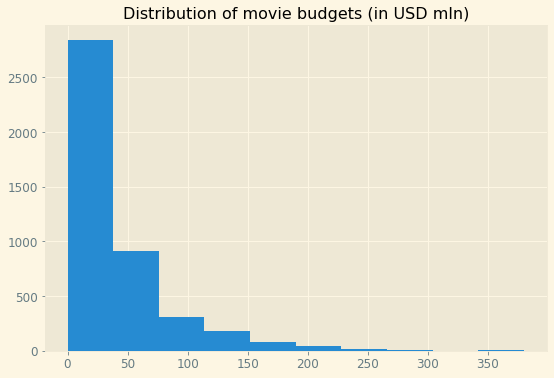

In [16]:
movies.budget.hist()
plt.title('Distribution of movie budgets (in USD mln)')
plt.show()

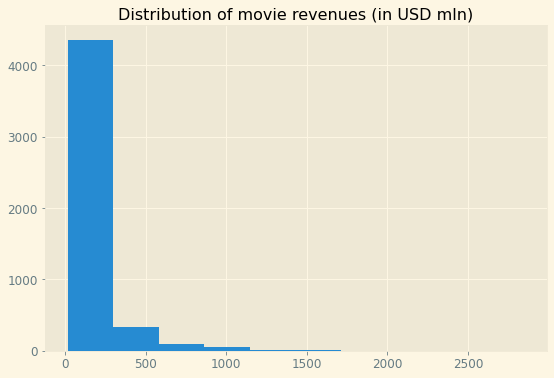

In [17]:
movies.revenue.hist()
plt.title('Distribution of movie revenues (in USD mln)')
plt.show()

As we can see, the distributions of movies budgets and revenues are highly skewed to the right. Most of the movies in the dataset have budget less than USD 100 mln  and revenue less than USD 500 mln. However, there are some significant outliers with budgets more then USD 350 mln and revenue more than USD 2000 mln.

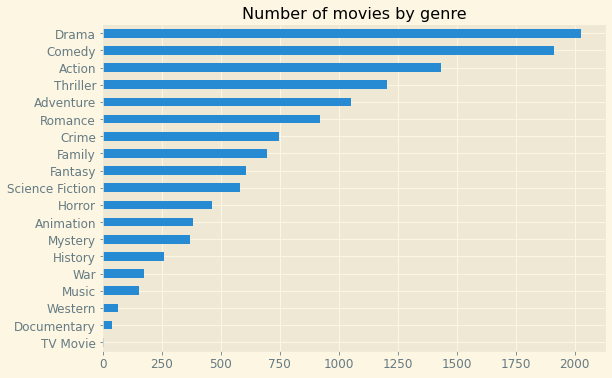

In [18]:
genres_sorted = movies.genres.str.get_dummies(sep=', ').sum().sort_values()
genres_sorted.plot.barh()
plt.title('Number of movies by genre')
plt.show()

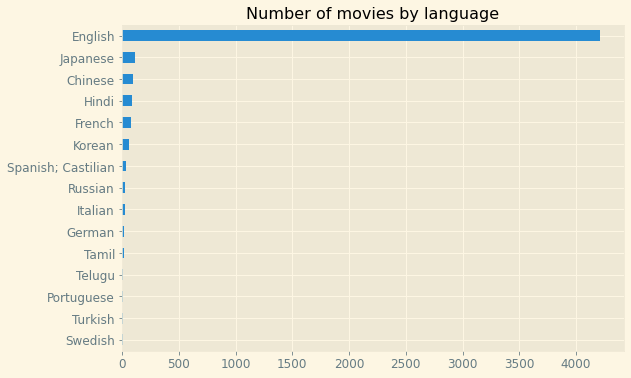

In [19]:
languages_sorted = movies.original_language.value_counts().sort_values()[-15:]
languages_sorted.plot.barh()
plt.title('Number of movies by language')
plt.show()

Drama and comedy are the most popular genres for the movies in the dataset. Absolute majority of the movies have English as their original language.

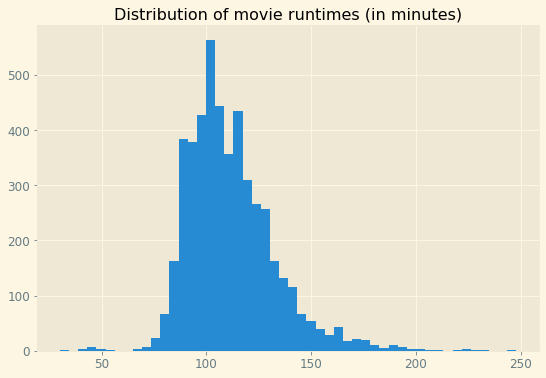

In [20]:
movies.runtime.hist(bins=50)
plt.title('Distribution of movie runtimes (in minutes)')
plt.show()

After removing films with less than 30 min duration, the ditribution of runtimes looks roughly normal with a slight skew to the right.

Let's have a look at the most popular actors, directors, and producers in the dataset.

In [21]:
#creating lists for unique values in columns with possible multiple values
all_years = movies.release_year.unique()
all_actors = movies.actors.str.get_dummies(sep=', ').columns
all_producers = movies.producers.str.get_dummies(sep=', ').columns
all_directors = movies.directors.unique()
all_genres = movies.genres.str.get_dummies(sep=', ').columns
all_studios = movies.studios.str.get_dummies(sep=', ').columns
all_countries = movies.countries.str.get_dummies(sep=', ').columns
all_languages = movies.original_language.unique()

In [22]:
actors_sorted = pd.DataFrame(movies.actors.str.get_dummies(sep=', ').sum().sort_values(ascending=False))
actors_sorted.rename(columns={0: 'number_of_movies'}).head(20)

,number_of_movies
Samuel L. Jackson,57
Robert De Niro,56
Bruce Willis,53
Morgan Freeman,48
Liam Neeson,46
Tom Hanks,45
Nicolas Cage,43
Johnny Depp,41
Tom Cruise,41
John Goodman,40


In [23]:
directors_sorted = pd.DataFrame(movies.directors.value_counts().sort_values(ascending=False))
directors_sorted.rename(columns={'directors': 'number_of_movies'}).head(20)

,number_of_movies
Clint Eastwood,31
Steven Spielberg,30
Ron Howard,23
Ridley Scott,21
Woody Allen,20
Tim Burton,17
Robert Zemeckis,16
Tyler Perry,16
Martin Scorsese,16
Joel Schumacher,15


In [24]:
producers_sorted = pd.DataFrame(movies.producers.str.get_dummies(sep=', ').sum().sort_values(ascending=False))
producers_sorted.rename(columns={0: 'number_of_movies'}).head(20)

,number_of_movies
Scott Rudin,55
Joel Silver,55
Brian Grazer,53
Eric Fellner,53
Tim Bevan,52
Neal H. Moritz,52
Arnon Milchan,43
Jason Blum,41
Jerry Bruckheimer,40
John Davis,40


Finally, let's have a look at the change in the number of movies in the dataset per year.

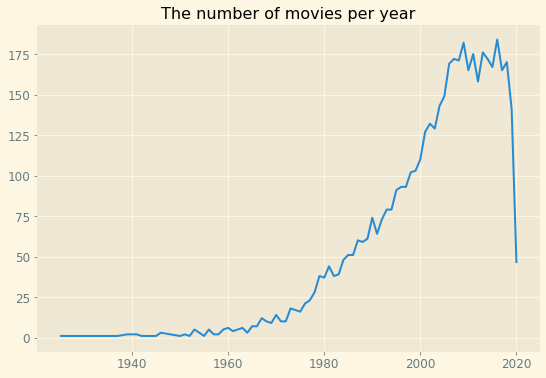

In [25]:
movies.release_year.value_counts().sort_index().plot()
plt.title('The number of movies per year')
plt.show()

As we can see, the number of films in this dataset increase gradually and peaks around 2005-2015 before falling sharply in 2020.

Let's have a look at the relations between movie revenue and various features of the dataset. Before claculating mean revenue for different groups of features, I'll ensure that these groups are reasonabky representatives. I.e. to calculate mean movie revenue per actor/director/producer, I'll only select only those actors/directors/producers that appear in at least some minimum number of films from the dataset. 

In [26]:
#functions for selecting values that appear in the dataframe at least min_n times
def values_to_groupby(column, array, min_n):
    to_groupby = []
    for value in array:
        if type(value) == str:
            if len(movies[movies[column].str.contains(value)]) >= min_n:
                to_groupby.append(value)
        else:
            if len(movies[movies[column]==value]) >= min_n:
                to_groupby.append(value)
    return to_groupby

In [27]:
#imputing missing values for producers and studios with 'Unknown'
movies.producers.fillna('Unknown', inplace=True)
movies.studios.fillna('Unknown', inplace=True)

In [28]:
#keeping only years which have at least 20 films
years_to_groupby = values_to_groupby('release_year', all_years, 20)

#keeping only actors that appear in at least 5 films
actors_to_groupby = values_to_groupby('actors', all_actors, 5)

#keeping only directors that have at least 3 films
directors_to_groupby = values_to_groupby('directors', all_directors, 3)

#keeping only producers that have at least 5 films
producers_to_groupby = values_to_groupby('producers', all_producers, 5)

#keeping only studios that have at least 5 films
studios_to_groupby = values_to_groupby('studios', all_studios, 5)

#keeping only countries that have at least 5 films
countries_to_groupby = values_to_groupby('countries', all_countries, 5)

C:\Users\oleks\AppData\Local\Temp/ipykernel_8560/2489413417.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if len(movies[movies[column].str.contains(value)]) >= min_n:


In [29]:
def get_average_revenue(array, column):
    revenue_dict = {}
    for value in array:
        if type(value) == str:
            revenue = movies[movies[column].str.contains(value)].revenue.mean()
            revenue_dict[value] = revenue
        else:
            revenue = movies[movies[column]==value].revenue.mean()
            revenue_dict[value] = revenue
    df = pd.DataFrame(data=revenue_dict.values(), index=revenue_dict.keys(), columns=['average_revenue'])
    return df

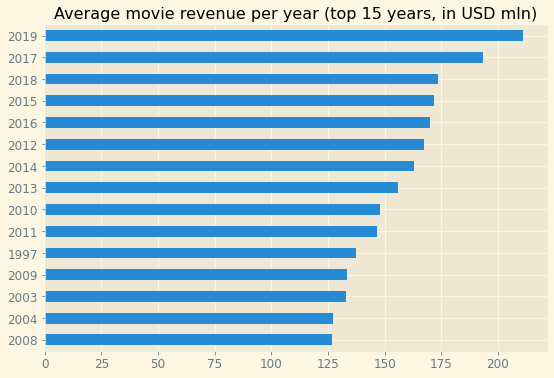

In [30]:
revenue_per_genre = get_average_revenue(years_to_groupby, 'release_year')
revenue_per_genre.average_revenue.sort_values().tail(15).plot.barh()
plt.title('Average movie revenue per year (top 15 years, in USD mln)')
plt.show()

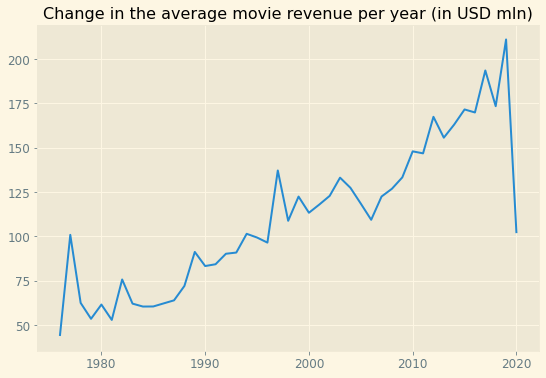

In [31]:
revenue_per_genre.sort_index().average_revenue.plot()
plt.title('Change in the average movie revenue per year (in USD mln)')
plt.show()

Not suprisingly, movied released in the most recent years have higher avarge revenue. That is, until 2020 when the revenue dropped significantly due to the COVID-19 pandemic.

In [32]:
#top 15 actors with highest mean revenue of associated films (among actors with at least 5 appearances)
revenue_per_actor = get_average_revenue(actors_to_groupby, 'actors')
revenue_per_actor.sort_values(by='average_revenue', ascending=False).head(15)

,average_revenue
Rupert Grint,963.360
Lupita Nyong'o,911.304
Chadwick Boseman,855.777
John Boyega,801.497
Anthony Daniels,762.266
Mark Hamill,759.591
Daniel Radcliffe,685.979
Ashley Greene,668.621
Nikki Reed,668.621
Bernard Hill,659.957


In [33]:
#top 15 directors with highest mean revenue of associated films (among directors with at least 3 films)
revenue_per_director = get_average_revenue(directors_to_groupby, 'directors')
revenue_per_director.sort_values(by='average_revenue', ascending=False).head(15)

,average_revenue
"Anthony Russo, Joe Russo",1368.507
Joss Whedon,987.696
David Yates,855.347
James Cameron,787.790
J.J. Abrams,775.560
Andrew Stanton,693.589
Rich Moore,674.743
George Lucas,667.823
Peter Jackson,655.832
"Eric Darnell, Tom McGrath",630.962


In [34]:
#top 15 producers with highest mean revenue of associated films (among producers with at least 5 films)
revenue_per_producer = get_average_revenue(producers_to_groupby, 'producers')
revenue_per_producer.sort_values(by='average_revenue', ascending=False).head(15)

,average_revenue
Kevin Feige,977.640
Tom DeSanto,848.359
David Barron,743.394
James Cameron,742.307
Fran Walsh,732.414
Janet Healy,692.593
Matt Tolmach,688.188
Christopher Nolan,670.839
Barrie M. Osborne,653.058
Darla K. Anderson,651.111


In [35]:
#top 15 studis with highest mean revenue of associated films (among studios with at least 5 films)
revenue_per_studio = get_average_revenue(studios_to_groupby, 'studios')
revenue_per_studio.sort_values(by='average_revenue', ascending=False).head(15)

,average_revenue
Marvel Studios,919.510
Lightstorm Entertainment,839.946
Matt Tolmach Productions,816.814
Illumination Entertainment,639.886
Pixar,635.534
Heyday Films,625.188
DC Films,622.925
Syncopy,584.397
Lucasfilm,576.183
Laura Ziskin Productions,574.522


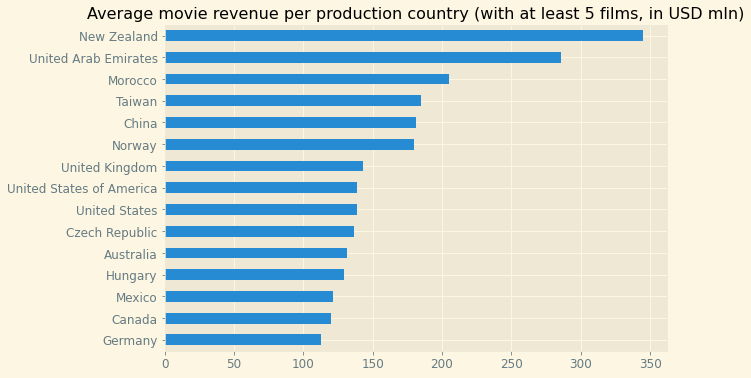

In [36]:
#top 15 production countries with highest mean revenue of associated films (among countries with at least 5 films)
revenue_per_country = get_average_revenue(countries_to_groupby, 'countries')
revenue_per_country.average_revenue.sort_values().tail(15).plot.barh()
plt.title('Average movie revenue per production country (with at least 5 films, in USD mln)')
plt.show()

Movies shot/produced in New Zealand have the highest average revenue. Judging from this and other countries from the top of the list, this might say something about the popularity of movies with exotic scenery.

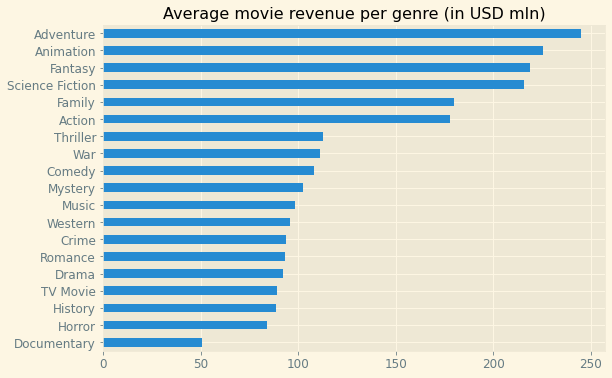

In [37]:
#average movie revenue per genre
revenue_per_genre = get_average_revenue(all_genres, 'genres')
revenue_per_genre.average_revenue.sort_values().plot.barh()
plt.title('Average movie revenue per genre (in USD mln)')
plt.show()

Among genres, adventure movies have the highest revenue on average. Most likely, this has to do with the popularity of superhero movies. Science fiction, animation, and fantasy also fare well, confirming the viewers' interest in entertainment movies. Drama, the most popular genre among the films in the dataset, is associated with much less revenue.

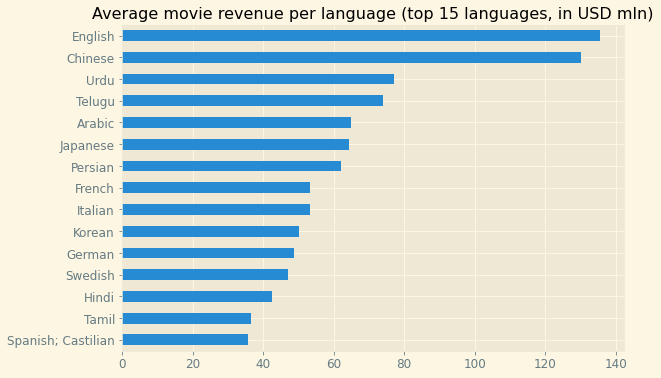

In [38]:
#average revenue per language
revenue_per_language = get_average_revenue(all_languages, 'original_language')
revenue_per_language.average_revenue.sort_values().tail(15).plot.barh()
plt.title('Average movie revenue per language (top 15 languages, in USD mln)')
plt.show()

English-language movie have the highest revenue on average, followed closely by Chinese-language movie. The latter probably has something to do with large Chinese-speaking audience. Howevere, we must keep in mind the high imbalance in the number of movies per class: English-language films account for more than 86% of all movies in the dataset.

I am also interested in correlation between movie budget and revenue. Due to the number of outliers, I decided to create several plots for movies with that have different budgets. For this, I'll divide all movie budgets into four equal quantiles:
1. 25% of movies with lowest budgets.
2. 25% of movies with budgets greater than the first group but below average.
3. 25% of movies with budgets greater than average but below the forth group.
4. 25% of movies with highest budgets.

In [39]:
#function for getting cuttoff points accodring to the amount of movie budget
def get_budget_quantiles(lower_quantile, upper_quantile):
    budget_quantile_df = movies[
        (movies.budget>movies.budget.quantile(lower_quantile)) & 
        (movies.budget<=movies.budget.quantile(upper_quantile))
    ]
    return budget_quantile_df

In [40]:
#getting numbers for four quantiles of movies dbudget amounts
#creating four dataframes according to the defined cutoff points
quantiles = [0.25, 0.5, 0.75, 1]
budget_quantiles = []
budget_quantile_dfs = []
for q in quantiles:
    budget_quantile = movies.budget.quantile(q)
    budget_quantiles.append(budget_quantile)
    budget_quantile_df = get_budget_quantiles(q-0.25, q)
    budget_quantile_dfs.append(budget_quantile_df)

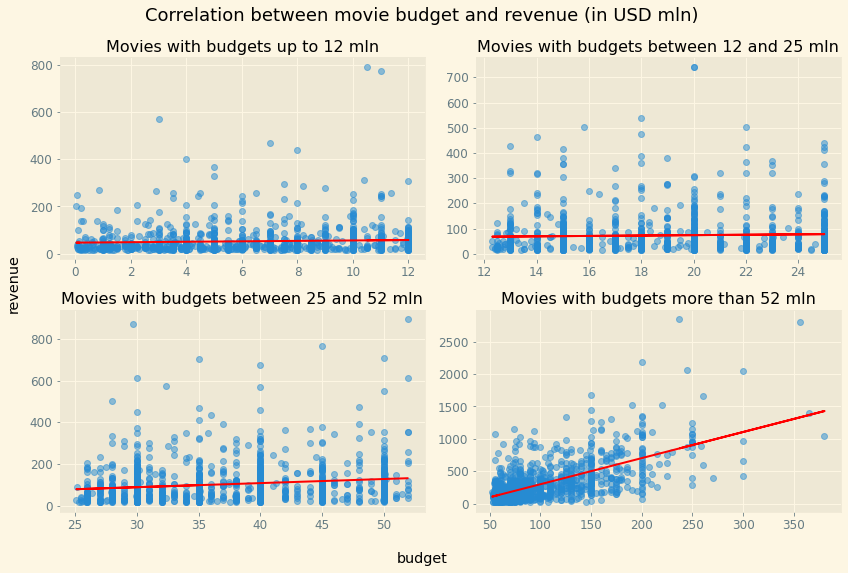

In [41]:
#plotting correlation between budget and revenue grouped by the
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for ax, i in zip (axs.flat, range(0, 4)):
    x = budget_quantile_dfs[i].budget
    y = budget_quantile_dfs[i].revenue
    ax.scatter(x, y, alpha=0.5)
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b, c='red')

axs[0, 0].set_title(f'Movies with budgets up to {round(budget_quantiles[0])} mln')
axs[0, 1].set_title(f'Movies with budgets between {round(budget_quantiles[0])} and {round(budget_quantiles[1])} mln')
axs[1, 0].set_title(f'Movies with budgets between {round(budget_quantiles[1])} and {round(budget_quantiles[2])} mln')
axs[1, 1].set_title(f'Movies with budgets more than {round(budget_quantiles[2])} mln')

fig.suptitle('Correlation between movie budget and revenue (in USD mln)', size=18)
fig.supxlabel('budget')
fig.supylabel('revenue')
fig.tight_layout()
plt.show()

It is clear from the plots that there is no correlation between budget and revenue if a budget is small. Correlation only starts to show for movies with large budgets.

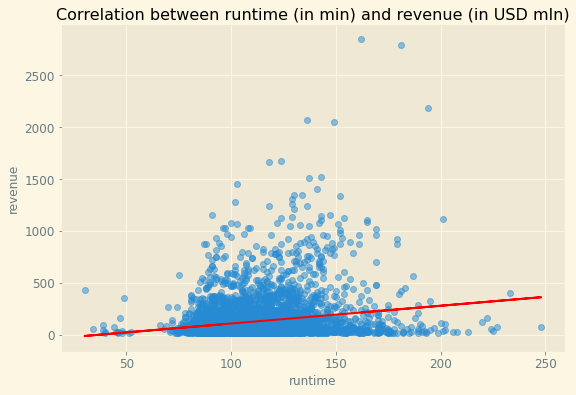

In [42]:
#plotting the correlation between runtime and revenue
plt.figure(figsize=(9, 6))
plt.scatter(x='runtime', y='revenue', data=movies, alpha=0.5)
plt.title('Correlation between runtime (in min) and revenue (in USD mln)')
x, y = movies.runtime, movies.revenue
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, c='red')
plt.xlabel('runtime')
plt.ylabel('revenue')
plt.show()

It looks like there is a weak linear correlation between movie runtime and revenue: longer movies tend to have slighly higher revenue. The highest grossing movies have runtime between 100 and 200 minutes.

I'll also look at the change in average runtime of movies in the dataset. Do movies get longer with each year?

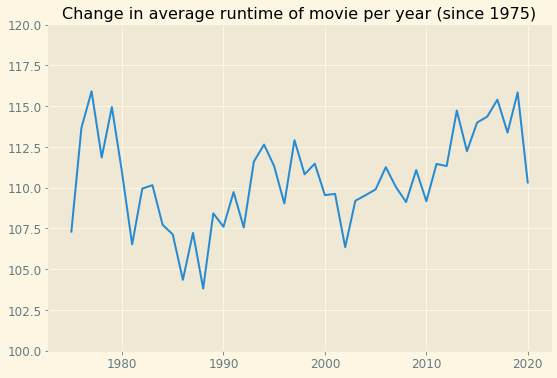

In [43]:
movies.groupby('release_year')['runtime'].mean().loc[1975:].sort_index().plot()
plt.ylim(100, 120)
plt.title('Change in average runtime of movie per year (since 1975)')
plt.xlabel('')
plt.show()

Looks like the average movie length hasn't changed much since 1975. Is this also the case if we take into account only 10 highest-grossing movies per year?

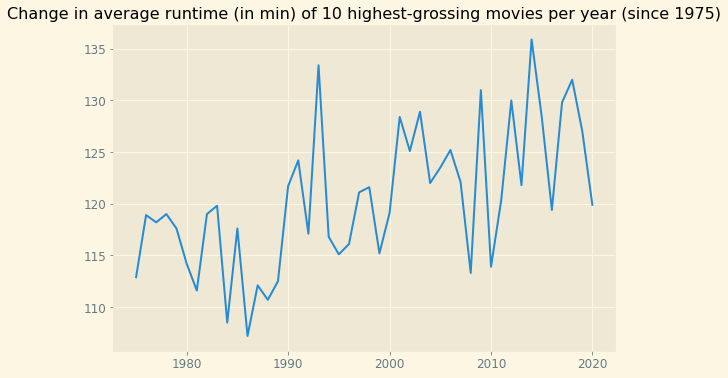

In [44]:
runtimes = {}
for year in range(1975, 2021):
    avg_runtime = movies[movies.release_year==year].sort_values(by='revenue', ascending=False).head(10).runtime.mean()
    runtimes[year] = avg_runtime
    
pd.Series(runtimes).plot()
plt.title('Change in average runtime (in min) of 10 highest-grossing movies per year (since 1975)')
plt.show()

There seem to be a slight overall trend towards longer movies among 10 highest-grossing movies per year, but it is not very pronounced.

Finally, let's plot a correlation heatmap to have a look at other possible correlations between numeric features.

<AxesSubplot:>

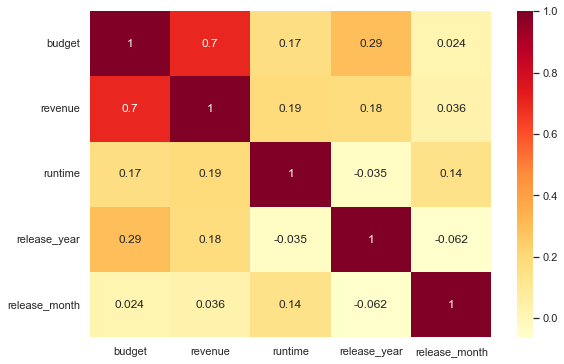

In [45]:
sns.set(rc={'figure.figsize':(9, 6)})

correlations = movies.corr()

sns.heatmap(correlations, annot=True, cmap='YlOrRd', fmt='.2g')

There is no signicficant correlation aside from the one between movie budget and revenue. Moreover, as we realized before, it only starts to show when movie budgets become large.

## Model bulding and predition

Next, I will try to predict movie revenue based on its features available in this dataset. For this task, I will try liner and non-linear regression models: Linear Regression, Ridge, Lasso (all linear), and Random Forest (non-linear).

In the dataframe, I still have missing values for budgets of some movie that I need to impute before feeding the dataset to the model. Also, I will preprocess or drop other columns as part of feature engineering:
* _budget_: impute missing values using KNNImputer and then apply StandradScaler;
* _genres_: apply one hot encoding;
* _original_language_: apply manual one hot encoding;
* _original_title_: drop (it has no predictive value);
* _release_date_: drop (I will use release year and month instead);
* _runtime_: apply StandradScaler;
* _actors_: drop (too much values to use one hot encoding);
* _studios_: drop (too much values to use one hot encoding);
* _countries_: apply manual one hot encoding;
* _directors_: drop (too much values to use one hot encoding);
* _producers_: drop (too much values to use one hot encoding);
* _release_year_: apply one hot encoding;
* _release_month_: apply one hot encoding.

In [46]:
#applying manual one hot encoding to the columns with multiple values
unique_values_list = [all_genres, all_languages, all_countries]
columns_to_encode = ['genres', 'original_language', 'countries']

for unique_values, column in zip(unique_values_list, columns_to_encode):
    for value in unique_values:
        movies[value] = np.where(movies[column].str.contains(value), 1, 0)
        
movies.drop(columns=columns_to_encode, inplace=True)

C:\Users\oleks\AppData\Local\Temp/ipykernel_8560/1486360847.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  movies[value] = np.where(movies[column].str.contains(value), 1, 0)


In [47]:
cols_to_drop = ['original_title', 'release_date', 'actors', 'studios', 'directors', 'producers']
movies_reduced = movies.drop(columns=cols_to_drop)

In [48]:
#importing necessary sklearn modules
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

I'll divide the dataframe into train and test using train_test_split. On the training porting, I will use simple 5-fold cross validation to evaluate performance of the models and tune their hyperparameters. As evaluation metrics, I will use root mean squared error (RMSE) and mean absolute error (MAE). I will then select the model that produces the lowest error and predict revenue for the training set. Finally, I will calculate R-squared score to udnerstand how much of the variability in movie revenue is explained by the model.

In [49]:
X = movies_reduced.drop(columns='revenue')
y = movies_reduced.revenue

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

In [50]:
#imputing missing values in budget column using KNNImputer
knn_imp = KNNImputer()
X_train.budget = knn_imp.fit_transform(X_train[['budget']]).flatten()
X_test.budget = knn_imp.transform(X_test[['budget']]).flatten()

In [51]:
#instantiating neccessary objects
ohe = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()
simp = SimpleImputer()
ct = make_column_transformer(
    (scaler, ['budget', 'runtime']),
    (ohe, ['release_year', 'release_month']),
    remainder='passthrough'
)
lr = LinearRegression(fit_intercept=False)
ridge = Ridge(random_state=17)
lasso = Lasso(random_state=17)
rf = RandomForestRegressor(random_state=17)

I will wrap data preprocessing and algorithm application into a pipeline.

In [52]:
# creating a pipeline that combines column transformer and a regressor model
models = [lr, ridge, lasso, rf]
model_names = []
rmses = []
maes = []
errors = ['neg_mean_absolute_error', 'neg_root_mean_squared_error']
for model in models:
    pipe = make_pipeline(ct, model)
    val_results = cross_validate(pipe, X_train, y_train, scoring=errors)
    rmse_mean = val_results['test_neg_root_mean_squared_error'].mean() * -1
    mae_mean = val_results['test_neg_mean_absolute_error'].mean() * -1
    model_name = type(pipe[1]).__name__
    model_names.append(model_name)
    rmses.append(rmse_mean)
    maes.append(mae_mean)

In [53]:
pd.DataFrame({'model': model_names, 'MAE': maes, 'RMSE': rmses})

,model,MAE,RMSE
0,LinearRegression,219545153331.617,2433696773662.406
1,Ridge,82.093,130.174
2,Lasso,78.595,130.145
3,RandomForestRegressor,71.401,130.377


With default hyperparameters, Linear Regression produces unrealistically huge error, probably due to the lack of regularization. On the other hand, Ridge and Lasso that are also linear models but use regularization shows results similar to those of Random Fores, which is a non-linear algorithm. I'll proceed to tuning hyperparameters for Ridge and Lasso, as well as Random Forest.

In [54]:
#increasing the number of iterations to allow Lasso to converge
lasso = Lasso(max_iter=10000)

alphas = [0.01, 0.1, 0.5, 1, 10, 100]

linear_models = [ridge, lasso]
linear_model_names = ['Ridge', 'Lasso']
lm_param_grids = [{'ridge__alpha': alphas}, {'lasso__alpha': alphas}]

lm_best_params = []
lm_best_rmses = []
lm_best_maes = []

for model, param_grid in zip(linear_models, lm_param_grids):
    
    lm_pipe = make_pipeline(ct, model)
    grid = GridSearchCV(lm_pipe, param_grid, scoring=errors, refit='neg_mean_absolute_error')
    grid.fit(X_train, y_train)
    
    lm_results = pd.DataFrame(grid.cv_results_)
    lm_best_result = lm_results[lm_results.rank_test_neg_mean_absolute_error==1]
    
    lm_best_param = lm_best_result.params.item()
    lm_best_params.append(lm_best_param)
    
    lm_best_mae = lm_best_result.mean_test_neg_mean_absolute_error.item() * -1
    lm_best_maes.append(lm_best_mae)
    
    lm_best_rmse = lm_best_result.mean_test_neg_root_mean_squared_error.item() * -1
    lm_best_rmses.append(lm_best_rmse)
        
lm_best_results = pd.DataFrame({
    'model': linear_model_names, 
    'best_mae': lm_best_maes, 
    'best_rmse': lm_best_rmses, 
    'best_params': lm_best_params
})

In [55]:
rf_pipe = make_pipeline(ct, rf)
rf_params = {
    'randomforestregressor__n_estimators': [10, 50, 100],
    'randomforestregressor__max_depth': [5, 10, None],
    'randomforestregressor__min_samples_split': [2, 4, 6],
    'randomforestregressor__min_samples_leaf': [1, 3, 5],
    'randomforestregressor__max_samples': [0.6, 0.8, 1],
    'randomforestregressor__max_features': [0.6, 0.8, 1]
}

grid = GridSearchCV(rf_pipe, rf_params, scoring=errors, refit='neg_mean_absolute_error', n_jobs=-1)
grid.fit(X_train, y_train)
rf_results = pd.DataFrame(grid.cv_results_)
rf_best_result = rf_results[rf_results.rank_test_neg_mean_absolute_error==1]

In [56]:
rf_best_mae = rf_best_result.head(1).mean_test_neg_mean_absolute_error.item() * -1
rf_best_rmse = rf_best_result.head(1).mean_test_neg_root_mean_squared_error.item() * -1
rf_best_params = rf_best_result.head(1).params.item()

best_results = lm_best_results.append({
    'model': 'Random Forest',
    'best_mae': rf_best_mae,
    'best_rmse': rf_best_rmse,
    'best_params': rf_best_params
}, ignore_index=True)

best_results

,model,best_mae,best_rmse,best_params
0,Ridge,78.462,129.120,{'ridge__alpha': 100}
1,Lasso,77.621,132.864,{'lasso__alpha': 10}
2,Random Forest,69.421,126.655,"{'randomforestregressor__max_depth': None, 'ra..."


After hyperparameter tuning, Random Forest showed the best performance in terms on both lower MAE and lower RMSE. I will use tuned Random Forest to predict revenue of the movies from the test dataset.

In [57]:
best_pipe = grid.best_estimator_
best_pipe.fit(X_train, y_train)
preds = best_pipe.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)
mae = mean_absolute_error(y_test, preds)
r_2 = best_pipe.score(X_test, y_test)

print(f'MAE of predictions on the test set using tuned Random Forest is: {mae:.3f}')
print(f'RMSE of predictions on the test set using tuned Random Forest is: {rmse:.3f}')
print(f'R-squared for the test set is: {r_2:.4f}')

MAE of predictions on the test set using tuned Random Forest is: 72.641
RMSE of predictions on the test set using tuned Random Forest is: 136.007
R-squared for the test set is: 0.5699


From the MAE metric results, we can say that, on average, the predicted revenue of movies differed from their actual revenue by USD 72.641 mln. RMSE is significantly higher in this case because it penalises more large differences between predicted and actual numbers. In our case, this must be caused by several outliers with very high revenue.

Using r-squared metric, we can also say that the features that were used by the algorithm accounted for 56.99% variability in the distribution of the target variable, i.e. movie revenue, in the test dataset. This means that we can improve the performance of the model by adding more relevant features that can impact movie revenue. Such features could include movie actors, directors, and producers that we discarded for this task due to the large number of unique values in each group and relatively small dataset. However, if we increase the number of movies significantly, we can try using these features as well. In addition, adding more films to the dataset, while checking accuracy of the new data, can also improve accuracy of predictions.

Let's have a look if we can learn something useful from the feature importances returned by the Random Forest model.

In [58]:
feature_names = best_pipe[0].get_feature_names_out()
feature_importances = best_pipe[1].feature_importances_
pd.DataFrame({
    'feature_name': feature_names, 
    'feature_importance': feature_importances
}).sort_values(by='feature_importance', ascending=False).head(20)

,feature_name,feature_importance
0,standardscaler__budget,0.691
1,standardscaler__runtime,0.111
93,remainder__Adventure,0.053
100,remainder__Fantasy,0.014
94,remainder__Animation,0.013
85,onehotencoder__release_month_6,0.009
92,remainder__Action,0.008
106,remainder__Science Fiction,0.008
98,remainder__Drama,0.007
78,onehotencoder__release_year_2019,0.006


The most important feature for predicting revenue using Random Forest is movie budget, followed by the runtime and whether a movie has Adventure as it genre.